In [1]:
from PIL import Image
import numpy as np
import os
import cv2

In [2]:
data=[]
labels=[]
size=299
Sol=os.listdir("./Data/Sol/")
for taj in Sol:
    imag=cv2.imread("./Data/Sol/"+taj)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(0)

Taj_Mahal=os.listdir("./Data/Taj_Mahal")
for taj in Taj_Mahal:
    imag=cv2.imread("./Data/Taj_Mahal/"+taj)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(1)
    
Tour_Effel=os.listdir("./Data/Tour_Effel")
for tour in Tour_Effel:
    imag=cv2.imread("./Data/Tour_Effel/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(2)
    
Big_Ben=os.listdir("./Data/Big_Ben/")
for tour in Big_Ben:
    imag=cv2.imread("./Data/Big_Ben/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(3)
Towers=os.listdir("./Data/Towers")
for tour in Towers:
    imag=cv2.imread("./Data/Towers/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(4)

In [3]:
monuments=np.array(data)
labels=np.array(labels)

In [4]:
np.save("monuments",monuments)
np.save("labels",labels)

In [4]:
s=np.arange(monuments.shape[0])
np.random.shuffle(s)
monuments=monuments[s]
labels=labels[s]

In [5]:
num_classes=len(np.unique(labels))
data_length=len(monuments)
print(len(monuments))
num_classes

2402


5

In [7]:
x_train=monuments[:(int)(0.7*data_length)]
x_val=monuments[(int)(0.7*data_length):]
train_length=len(x_train)
val_length=len(x_val)
print(len(x_train))
print(len(x_val))

1681
721


In [8]:
y_train=labels[:(int)(0.7*data_length)]
y_val=labels[(int)(0.7*data_length):]
print(len(y_train))
print(len(y_val))

1681
721


In [9]:
import keras
from keras.utils import np_utils
#One hot encoding
y_train=keras.utils.to_categorical(y_train,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [10]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=.05, 
                                   width_shift_range=.05,
                                   height_shift_range=.05, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train,
                                     batch_size=BATCH_SIZE, seed=1)
                                     
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val, 
                                   batch_size=BATCH_SIZE, seed=1)

In [11]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 7s 0us/step


In [12]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Get the InceptionV3 model so we can do transfer learning


base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3))
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.7)(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.7)(out)
predictions = Dense(num_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
#model.summary()
learning_rate=1e-4
model.compile(optimizer = Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 32
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint('InceptionV3_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=1000, verbose=1,callbacks=[es, mc])

Epoch 1/1000
52/52 [==============================] - 43s 821ms/step - loss: 1.7451 - acc: 0.2542 - val_loss: 1.3874 - val_acc: 0.5043

Epoch 00001: val_acc improved from -inf to 0.50426, saving model to InceptionV3_best_model.h5
Epoch 2/1000
52/52 [==============================] - 30s 575ms/step - loss: 1.4689 - acc: 0.3796 - val_loss: 1.2360 - val_acc: 0.6168

Epoch 00002: val_acc improved from 0.50426 to 0.61684, saving model to InceptionV3_best_model.h5
Epoch 3/1000
52/52 [==============================] - 32s 616ms/step - loss: 1.3048 - acc: 0.4609 - val_loss: 1.1169 - val_acc: 0.5936

Epoch 00003: val_acc did not improve from 0.61684
Epoch 4/1000
52/52 [==============================] - 32s 621ms/step - loss: 1.1831 - acc: 0.5531 - val_loss: 0.9376 - val_acc: 0.7039

Epoch 00004: val_acc improved from 0.61684 to 0.70392, saving model to InceptionV3_best_model.h5
Epoch 5/1000
52/52 [==============================] - 32s 623ms/step - loss: 1.0124 - acc: 0.6212 - val_loss: 0.8260 -

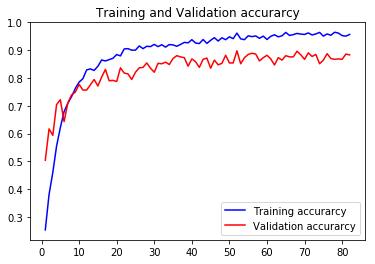

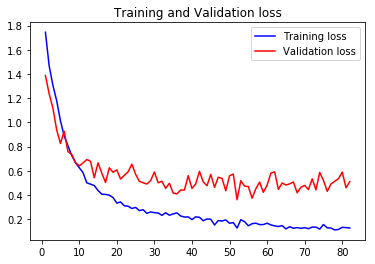

In [13]:
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [14]:
x_val.shape[0]

721

In [15]:
import numpy as np
val_acc = history.history['val_acc']
for i in range(len(val_acc)-30):
    
    print(str(val_acc[i]))

0.5042613636363636
0.6168359946270293
0.5936139339286461
0.7039187232191919
0.7213352691971512
0.642960813377696
0.7097242384586694
0.738751814569548
0.7489114660656158
0.7764876637126606
0.7561683602014716
0.7561683601149627
0.7750362849027913
0.7939042091715665
0.7706821482136564
0.8026124820307827
0.830188679331792
0.7895500728284672
0.7910014514653188
0.7866473153817464
0.8359941948307962
0.8171262701294765
0.8142235124232288
0.7940340909090909
0.8200290279222331
0.8359941945712694
0.8374455738136835
0.853410740289702
0.834542815847909
0.8200290279222331
0.8519593615663414
0.8505079829294899
0.8563134980824585
0.8476052250502244
0.869375907284774
0.8795355588673507
0.8751814224377426
0.8722786649910217
0.8417997100702737
0.8679245285614136
0.8577648767193101
0.8374455735541566
0.8664731495785263
0.8708272860946433
0.8345428157614001
0.8635703922183143
0.8465909090909091
0.8519593613933236
0.8809869376772201
0.8534107405492287
0.8534107402031931
0.8969521049318189
